In [1]:
import os
import time
import csv
import yaml
import torch
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.optim
from datetime import timedelta
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.transforms import Compose

from experiment import DPT
from util.callbacks import TensorCheckpoint
from dpt.models import DPTDepthModel
from dpt.loss import DepthMetrics 
from dataloader.nyu_loader import NYUDataset

In [2]:
config_path = "config/train.yaml"
                    

with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device name: {torch.cuda.get_device_name(0) if device != "cpu" else "cpu"}')


batch_size = config['experiment']['batch_size']
epochs = config['experiment']['epochs']
lr = config['experiment']['learning_rate']
logs_path = config['experiment']['logs_path']
model_path = config['model']['model_path']

net_w = 640
net_h = 480

device name: GeForce RTX 2080 Ti


In [4]:
val_dataset = NYUDataset(config['dataset']['data_path'], type='val')
loader = DataLoader(val_dataset,
                        batch_size=1,
                        prefetch_factor=10, # increase or decrease based on free gpu mem
                        pin_memory=True,
                        num_workers=4*torch.cuda.device_count() if torch.cuda.is_available() else 0)

metrics = DepthMetrics()
 

Found 1004 images in val folder.


In [5]:
# parameters = torch.load('/ssd_scratch/cvit/shan/logs/finetune/version_3/checkpoints/epoch=1-step=1003.ckpt')
# print(parameters["state_dict"].keys())

In [6]:
from dpt.models import DPTDepthModel

model = DPT(config)
model.cuda()

LOADED PRETRAINED MODEL


DPT(
  (criteria): MaskedL1Loss()
  (model): DPTDepthModel(
    (pretrained): Module(
      (model): VisionTransformer(
        (patch_embed): HybridEmbed(
          (backbone): ResNetV2(
            (stem): Sequential(
              (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
              (norm): GroupNormAct(
                32, 64, eps=1e-05, affine=True
                (act): ReLU(inplace=True)
              )
              (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
            )
            (stages): Sequential(
              (0): ResNetStage(
                (blocks): Sequential(
                  (0): Bottleneck(
                    (downsample): DownsampleConv(
                      (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (norm): GroupNormAct(
                        32, 256, eps=1e-05, affine=True
                        (

/home2/shanthika_naik/miniconda3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([1, 3, 480, 640]) torch.Size([480, 640, 1]) torch.Size([1, 480, 640])


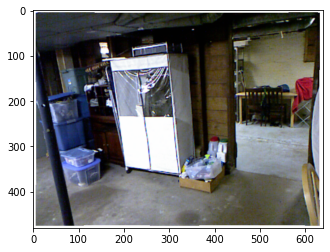

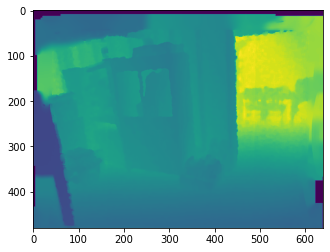

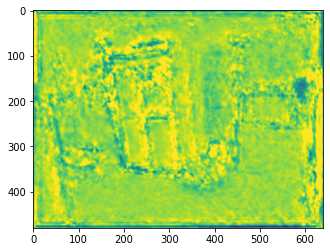

In [7]:
with torch.no_grad():
    for img,dep in loader:
        im, depth = img.to(device), dep.to(device)
        out = model(im)
        
        depth = depth.squeeze(0).permute([1,2,0]).cpu()

        print(im.shape,depth.shape,out.shape)
        plt.imshow(im.squeeze(0).permute([1,2,0]).cpu())
        plt.show()
        plt.imshow(depth)
        plt.show()
        plt.imshow(out.squeeze(0).cpu())
        plt.show()
        break